# Install necessary libraries 

In [ ]:
! pip install tensorflow
! pip install keras
! pip install tf2onnx onnx onnxruntime

# Preprocessing and train the model


Epoch 1/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 340s 4s/step - accuracy: 0.7239 - loss: 0.4445 - val_accuracy: 0.6909 - val_loss: 0.5885
Epoch 2/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 344s 4s/step - accuracy: 0.9691 - loss: 0.1405 - val_accuracy: 0.7341 - val_loss: 0.5276
Epoch 3/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 348s 4s/step - accuracy: 0.9987 - loss: 0.0232 - val_accuracy: 0.7750 - val_loss: 0.5290
Epoch 4/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.7864 - val_loss: 0.5470
Epoch 5/50
90/90 ━━━━━━━━━━━━━━━━━━━━ 358s 4s/step - accuracy: 1.0000 - loss: 9.2311e-04 - val_accuracy: 0.7864 - val_loss: 0.5744


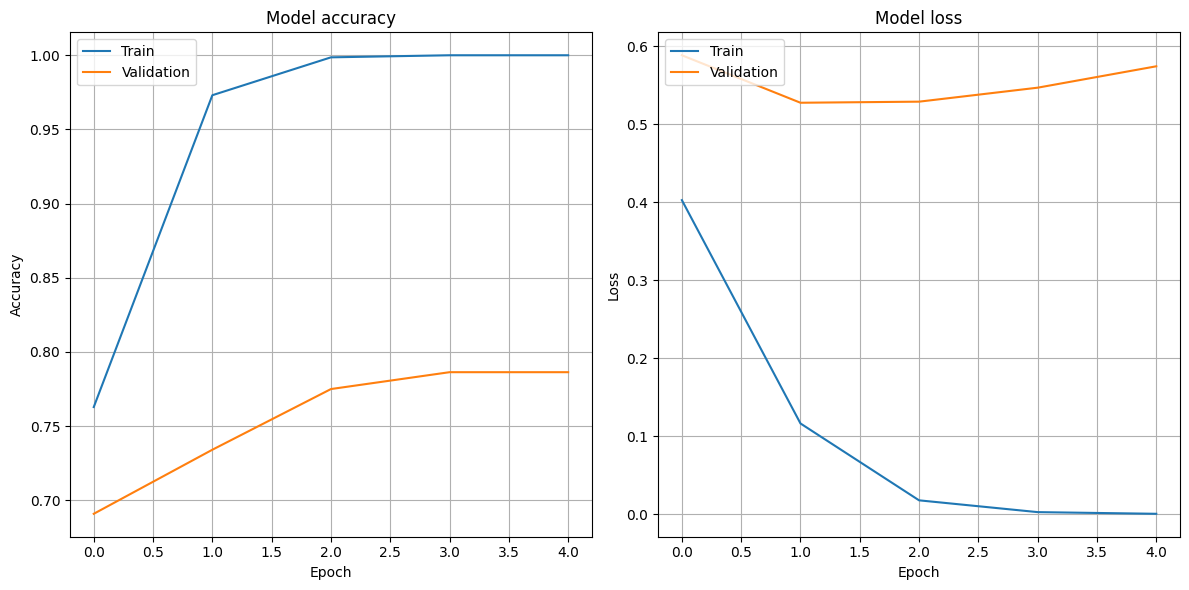

14/14 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.7450 - loss: 0.5253
Validation Loss, Validation Accuracy: [0.5276409387588501, 0.7340909242630005]
32/32 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8037 - loss: 0.4801
Test Loss, Test Accuracy: [0.5871765613555908, 0.7089999914169312]
32/32 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step


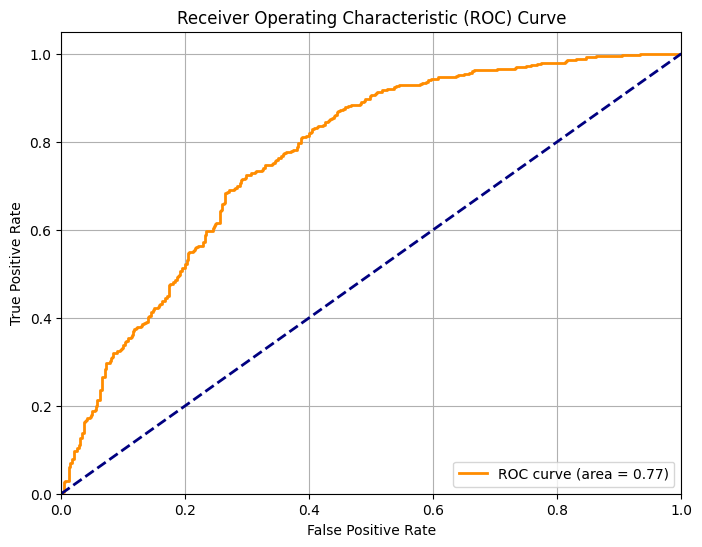

ROC-AUC: 0.77


In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the data
match_pairs = pd.read_csv('matchpairsDevTrain.csv')
mismatch_pairs = pd.read_csv('mismatchpairsDevTrain.csv')

# Combine and label the pairs
match_pairs['label'] = 1
mismatch_pairs['label'] = 0
pairs = pd.concat([match_pairs, mismatch_pairs], ignore_index=True)

# Directory where images are stored
image_directory = r'lfw-deepfunneled'

def load_image(name, imagenum):
    if pd.isna(name) or pd.isna(imagenum):
        return None
    imagenum_str = str(int(imagenum)).zfill(4)
    image_path = os.path.join(image_directory, name, f'{name}_{imagenum_str}.jpg')
    try:
        image = load_img(image_path, target_size=(224, 224), color_mode='rgb')  # VGG16 expects 224x224 RGB images
        image = img_to_array(image) / 255.0
        return image
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

def preprocess_pairs(pairs):
    images1, images2, labels = [], [], []
    for idx, row in pairs.iterrows():
        img1 = load_image(row['name'], row['imagenum1'])
        img2 = load_image(row['name'] if pd.isna(row.get('name.1')) else row['name.1'], row['imagenum2'])
        if img1 is not None and img2 is not None:
            images1.append(img1)
            images2.append(img2)
            labels.append(row['label'])
    return np.array(images1), np.array(images2), np.array(labels)

images1, images2, labels = preprocess_pairs(pairs)

# Split the data
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(images1, images2, labels, test_size=0.2, random_state=42)

# Define a function to generate augmented data
def generate_augmented_data(images, labels, target_count):
    augmented_images = []
    augmented_labels = []
    for image, label in zip(images, labels):
        augmented_images.append(image)
        augmented_labels.append(label)
        while len(augmented_images) < target_count[label]:
            augmented_image = datagen.random_transform(image)
            augmented_images.append(augmented_image)
            augmented_labels.append(label)
    return np.array(augmented_images), np.array(augmented_labels)

# Calculate the target count for each class
target_count = {label: max(np.sum(labels == label), 100) for label in np.unique(labels)}

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      
    width_shift_range=0.2,  
    height_shift_range=0.2, 
    shear_range=0.2,        
    zoom_range=0.2,         
    horizontal_flip=True,   
    fill_mode='nearest'     
)

# Generate augmented data
augmented_X1_train, augmented_y_train = generate_augmented_data(X1_train, y_train, target_count)
augmented_X2_train, _ = generate_augmented_data(X2_train, y_train, target_count)

# Shuffle the augmented data
augmented_X1_train, augmented_X2_train, augmented_y_train = shuffle(augmented_X1_train, augmented_X2_train, augmented_y_train)

# Define the Siamese Network using VGG16
def build_siamese_model(input_shape):
    base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    input = Input(input_shape)
    x = base_model(input)
    x = Flatten()(x)
    x = Dense(4096, activation='sigmoid')(x)
    return Model(input, x)

input_shape = (224, 224, 3)  # Adjust based on your image size
model = build_siamese_model(input_shape)

# Define the Siamese Network architecture
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = model(input_a)
processed_b = model(input_b)

# Define the distance measure
distance = Lambda(lambda embeddings: tf.abs(embeddings[0] - embeddings[1]))([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(distance)

# Create the Siamese Network model
siamese_network = Model([input_a, input_b], output)

# Compile the model with Adam optimizer and specific learning rate
optimizer = Adam(learning_rate=0.0001)
siamese_network.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the Siamese Network with augmented data and EarlyStopping
history = siamese_network.fit([augmented_X1_train, augmented_X2_train], augmented_y_train,
                              epochs=50, batch_size=32,
                              validation_data=([X1_test, X2_test], y_test),
                              callbacks=[early_stopping])

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

# Evaluate the model on the test set
results = siamese_network.evaluate([X1_test, X2_test], y_test)
print("Validation Loss, Validation Accuracy:", results)

# Load the test data
match_pairs_test = pd.read_csv('matchpairsDevTest.csv')
mismatch_pairs_test = pd.read_csv('mismatchpairsDevTest.csv')

# Combine and label the test pairs
match_pairs_test['label'] = 1
mismatch_pairs_test['label'] = 0
test_pairs = pd.concat([match_pairs_test, mismatch_pairs_test], ignore_index=True)

# Preprocess the test pairs
X1_test_pairs, X2_test_pairs, y_test_pairs = preprocess_pairs(test_pairs)

# Evaluate the model on the test set
test_results = siamese_network.evaluate([X1_test_pairs, X2_test_pairs], y_test_pairs)
print("Test Loss, Test Accuracy:", test_results)

# Compute ROC curve and ROC-AUC for test set
y_pred_test = siamese_network.predict([X1_test_pairs, X2_test_pairs]).ravel()
fpr, tpr, thresholds = roc_curve(y_test_pairs, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"ROC-AUC: {roc_auc:.2f}")


# Save the model

In [7]:
#save the model
model.save('my_model.keras')


# Convert the model to onnx

In [3]:

import tf2onnx
import tensorflow as tf
onnx_model_path = "siamese_model.onnx"
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input_a"),
        tf.TensorSpec((None,224, 224, 3), tf.float32, name="input_b"))

model_proto, _ = tf2onnx.convert.from_keras(siamese_network, input_signature=spec, opset=13)
with open(onnx_model_path, "wb") as f:
    f.write(model_proto.SerializeToString())

print(f"Model saved to {onnx_model_path}")



Model saved to siamese_model.onnx


# Convert the model to TRT

In [28]:
# # Convert to TensorRT (requires TensorRT installed and configured)
# import tensorrt as trt
# from tf2onnx import tfonnx, optimizer

# def build_engine(onnx_file_path):
#     TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
#     with trt.Builder(TRT_LOGGER) as builder, builder.create_network(1) as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
#         builder.max_workspace_size = 1 << 30
#         with open(onnx_file_path, 'rb') as model:
#             parser.parse(model.read())
#         return builder.build_cuda_engine(network)

# engine = build_engine(onnx_model_path)
# print("TensorRT engine built successfully.")


In [29]:
# import tensorrt as trt

# def build_engine(onnx_file_path):
#     TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
    
#     # Initialize TensorRT builder and network objects
#     with trt.Builder(TRT_LOGGER) as builder, builder.create_network() as network, trt.OnnxParser(network, TRT_LOGGER) as parser:
#         # Set the maximum workspace size (1GB in this example)
#         workspace_size = 1 << 30
#         builder.set_memory_allocator(None)
        
#         # Parse the ONNX model
#         with open(onnx_file_path, 'rb') as model:
#             if not parser.parse(model.read()):
#                 for error in range(parser.num_errors):
#                     print(parser.get_error(error))
#                 raise RuntimeError("Parsing ONNX file failed.")
        
#         # Set up the optimization profile (if needed)
#         profile = builder.create_optimization_profile()
#         profile.set_shape("input_name", (1, 3, 224, 224), (1, 3, 224, 224), (1, 3, 224, 224))
#         builder_config = builder.create_builder_config()
#         builder_config.add_optimization_profile(profile)

#         # Build and return the TensorRT engine
#         return builder.build_cuda_engine(network)

# # Path to the converted ONNX model file
# onnx_model_path = 'siamese_model.onnx'

# # Build the TensorRT engine from ONNX
# engine = build_engine(onnx_model_path)
# print("TensorRT engine built successfully.")






In [30]:
# import tensorrt as trt

# # Print TensorRT version
# print("TensorRT version:", trt.__version__)


In [31]:
# ! git clone https://github.com/gcunhase/torch2trt.git


In [32]:
# pip install torch torchvision torchaudio


In [33]:
# import tensorflow as tf

# # Load your Keras model (replace with your actual Keras model loading code)
# keras_model = tf.keras.models.load_model('my_model.keras')


In [35]:
# from torch2trt import keras_to_pytorch

# # Convert Keras model to PyTorch
# pytorch_model = keras_to_pytorch(keras_model)  


In [34]:
# from torch2trt import torch2trt
# import torch

# # Example dummy input (replace with your actual input shape)
# dummy_input = torch.randn(1, 3, 224, 224).cuda()

# # Convert PyTorch model to TensorRT engine
# model_trt = torch2trt(pytorch_model, [dummy_input])

# # Save the TensorRT engine to a file
# trt_engine_path = 'model.engine'
# torch.save(model_trt.state_dict(), trt_engine_path)

# print(f"TensorRT engine saved to {trt_engine_path}")
